# Decoded Quantum Interferometry Algorithm

In [1]:
import numpy as np
from itertools import product, combinations
import warnings
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import random
import pprint
pp = pprint.PrettyPrinter(depth=4)

# Qiskit imports for simulation and circuit construction
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace

# Custom module imports 
from initialization.state_preparation.gates import WeightedUnaryEncoding
from initialization.calculate_w import get_optimal_w, calculate_w
from initialization.construct_A import construct_A_matrix
from dicke_state_preparation.gates import UnkStatePreparation
from decoding.gates import GJEGate
from utils import *

warnings.filterwarnings("ignore")

## Graph Generation and Max-XORSAT Problem

Set parameters for the graph and search, then generate a random graph.  
Solve the Max-XORSAT problem by exhaustively finding assignments that maximize the number of satisfied XOR constraints.

Found a graph after 0 iterations!
Max-XORSAT Constraint Matrix (B):
[[1 0 0 0 0 1]
 [1 1 0 0 0 0]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 0 0 0 1]
 [0 0 0 1 0 1]]

Right-Hand Side Vector (v):
[1 1 1 1 1 1]

Maximum number of XOR constraints satisfied: 5
4 optimal assignments:
[0, 1, 0, 0, 0, 1]
[0, 1, 1, 0, 0, 1]
[1, 0, 0, 1, 1, 0]
[1, 0, 1, 1, 1, 0]


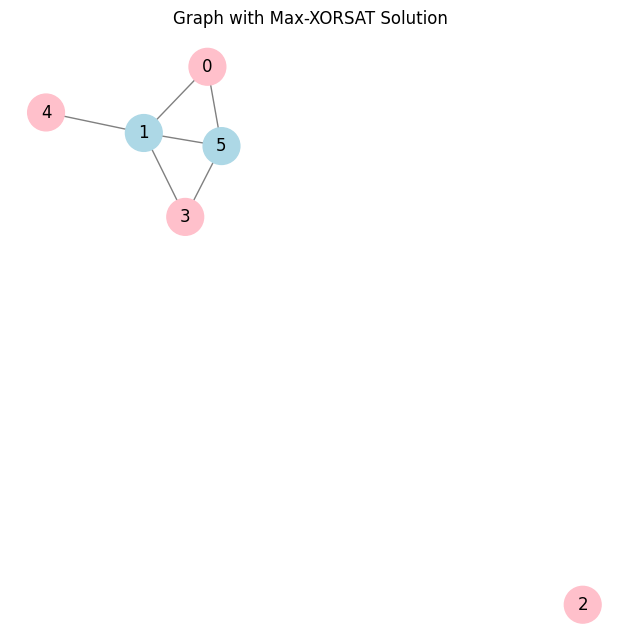

In [2]:
# Parameters for graph generation and search
num_nodes = 6              # Number of nodes (variables)
num_edges = 6              # Number of XOR constraints (edges)
target_max_solutions = None   # Desired number of optimal assignments
max_iter = 1000            # Maximum search iterations
seed = 666            # Random seed for reproducibility

# Flag to decide if statevector plots should be shown (only for small problems)
show_sv = (num_nodes * num_edges < 50)

# Search for a graph with exactly the target number of max solutions
result = find_graph_with_target_max_solutions(num_nodes, num_edges, target_max_solutions, seed, max_iter)
G, best_assignments, max_satisfied, iterations = result

if G is not None:
    print(f"Found a graph after {iterations} iterations!")
    B, v = get_max_xorsat_matrix(G, v=None)  # v defaults to all ones if not provided
    print("Max-XORSAT Constraint Matrix (B):")
    print(B)
    print("\nRight-Hand Side Vector (v):")
    print(v)
    print(f"\nMaximum number of XOR constraints satisfied: {max_satisfied}")
    print(f"{len(best_assignments)} optimal assignments:")
    for assignment in best_assignments:
        print(list(assignment.values()))
    # Visualize the graph using the first optimal assignment
    draw_graph(G, best_assignments[0])
else:
    print(f"No graph found in {max_iter} iterations that has exactly {target_max_solutions} maximum solutions.")

In [3]:
# B = np.array([
#     [1, 1, 1, 1],
#     [1, 1, 1, 1],
#     [1, 1, 1, 1],
#     [1, 1, 1, 1],
    
# ])

## Brute-Force Objective Landscape Visualization

Compute the brute-force objective values for every assignment and visualize the resulting landscape.
This plot will later be compared with the simulation data.


In [4]:
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results,
    {},
    plot_name="Objective Values Landscape",
    spline_smoothing=1.3
)


## Quantum Circuit Initialization and State Preparation

Prepare the quantum circuit components:

- **Weighted Unary Encoding:** Creates an initialization circuit based on optimal weights.
- **Dicke State Preparation:** Constructs a circuit to prepare a Dicke state used for error preparation.


In [5]:
n = len(B[0])  # Number of qubits corresponding to constraints
m, p, r, ell = len(B), 2, 1, 4  # Additional parameters for state preparation

# Compute optimal weight values for the initialization
w, _ = get_optimal_w(m, n, ell, p, r)
print("Optimal W_k value: ", w.tolist())

INFO:utils:Function 'get_optimal_w' executed in 0.002984 seconds.


Optimal W_k value:  [0.0, 0.2653199916576681, 0.5430481797287362, 0.6554428289536586, 0.45287821154622376, 0.0, 0.0, 0.0]


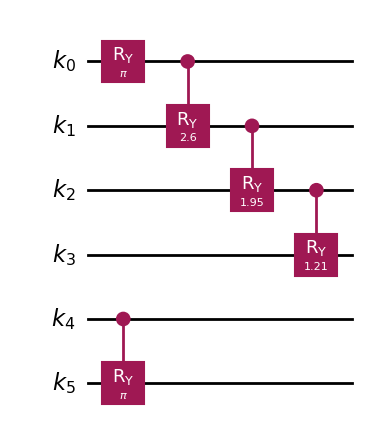

<IPython.core.display.Latex object>

In [6]:
# Build the initialization circuit using Weighted Unary Encoding
init_qregs = QuantumRegister(m, name='k')
initialize_circuit = QuantumCircuit(init_qregs)
WUE_Gate = WeightedUnaryEncoding(m, w)
initialize_circuit.append(WUE_Gate, range(m))
display(initialize_circuit.decompose().draw('mpl'))

if show_sv:
    display(Statevector(initialize_circuit).draw('latex'))


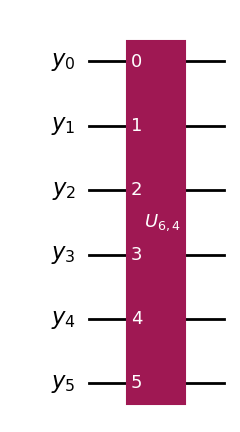

In [7]:
# Prepare the Dicke state circuit
dicke_qregs = QuantumRegister(m, name='y')
dicke_circuit = QuantumCircuit(dicke_qregs)
max_errors = int(np.nonzero(w)[0][-1]) if np.any(w) else 0
dicke_circuit.append(UnkStatePreparation(m, max_errors).to_gate(), range(m))
display(dicke_circuit.draw('mpl'))

## DQI Circuit Composition and Decoding

Build the DQI circuit by combining:

- The initialization and Dicke state circuits.
- Phase flip operations according to the right-hand side vector.
- Encoding of the constraint matrix via CNOT gates.

Then, construct the decoding circuit using the custom GJEGate.

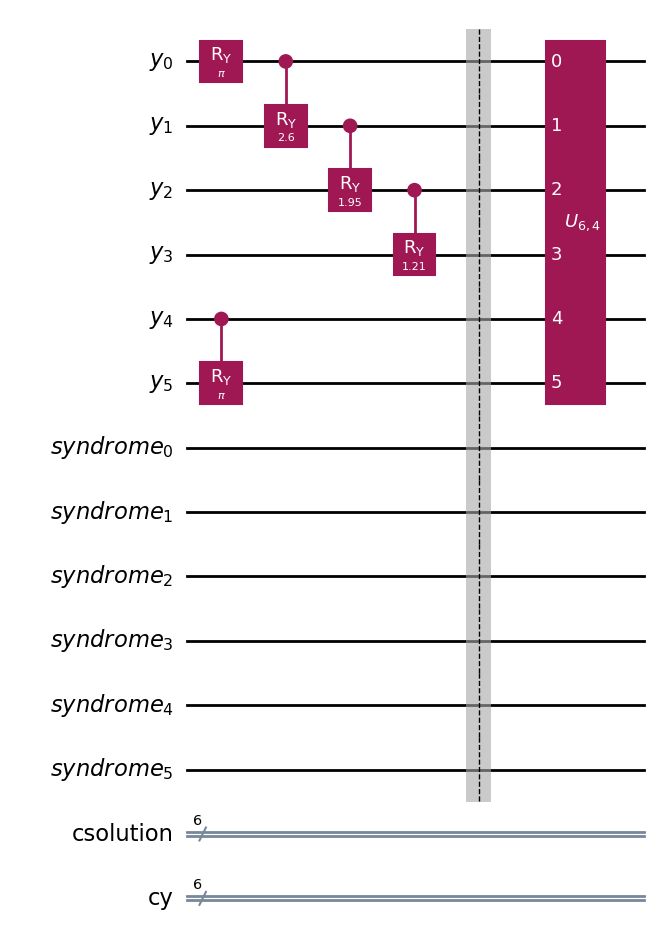

<IPython.core.display.Latex object>

In [8]:
# Create registers for syndrome and measurement
dicke_qregs = QuantumRegister(m, name='y') 
dicke_cregs = ClassicalRegister(m, name='cy')
syndrome_qregs = QuantumRegister(n, name='syndrome')
syndrome_cregs = ClassicalRegister(syndrome_qregs.size, name='csolution')

# Build the DQI circuit by composing initialization and Dicke circuits
dqi_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs, syndrome_cregs, dicke_cregs)
dqi_circuit.compose(initialize_circuit, inplace=True)
dqi_circuit.barrier()
dqi_circuit.compose(dicke_circuit, inplace=True)
display(dqi_circuit.decompose().draw('mpl'))
if show_sv:
    display(Statevector(dqi_circuit).draw('latex'))

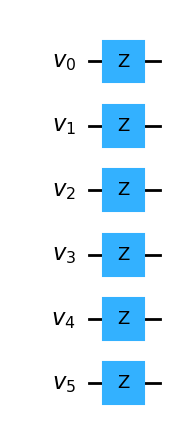

In [9]:
# Apply phase flip operations based on v
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(len(v)):
    if v[i] == 1:
        v_phase_flip_circuit.z(i)
display(v_phase_flip_circuit.draw('mpl'))

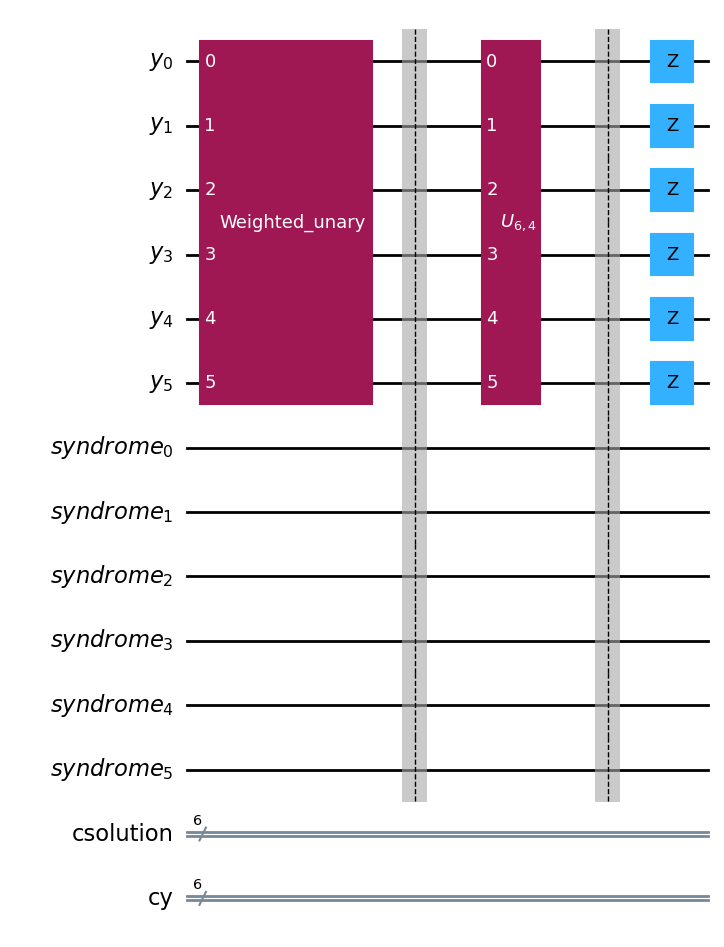

In [10]:
dqi_circuit.barrier()
dqi_circuit.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
display(dqi_circuit.draw('mpl'))

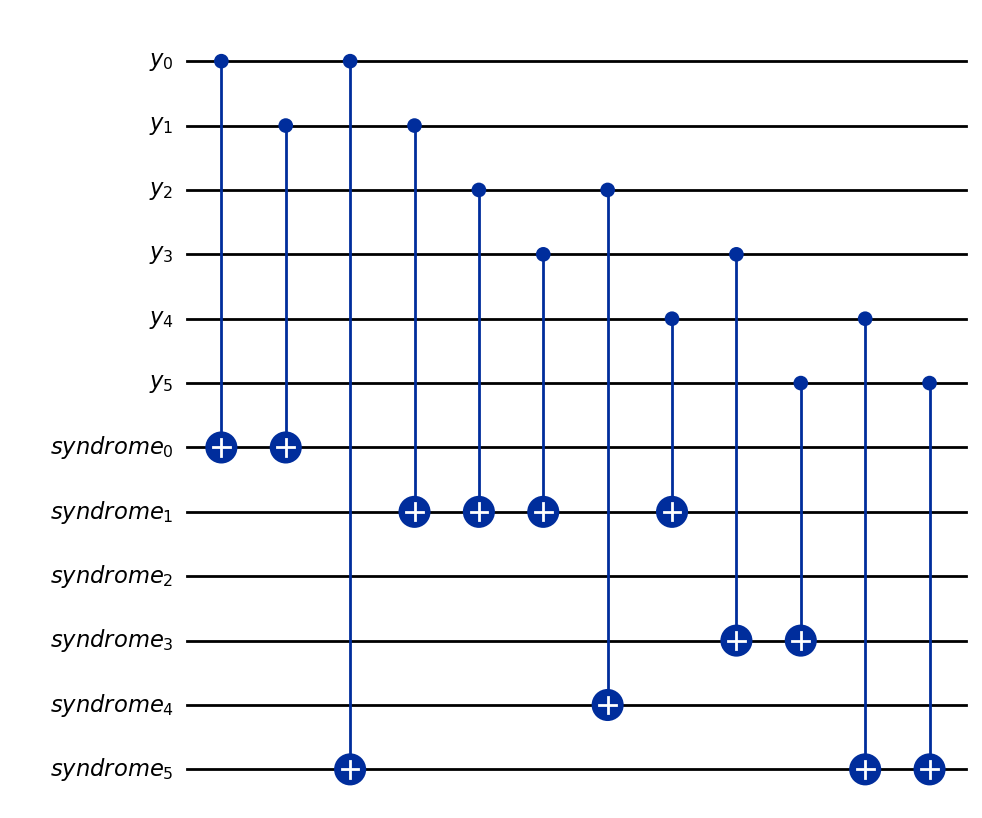

In [11]:
# Encode the constraint matrix B using CNOT gates
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
display(B_circuit.draw('mpl'))

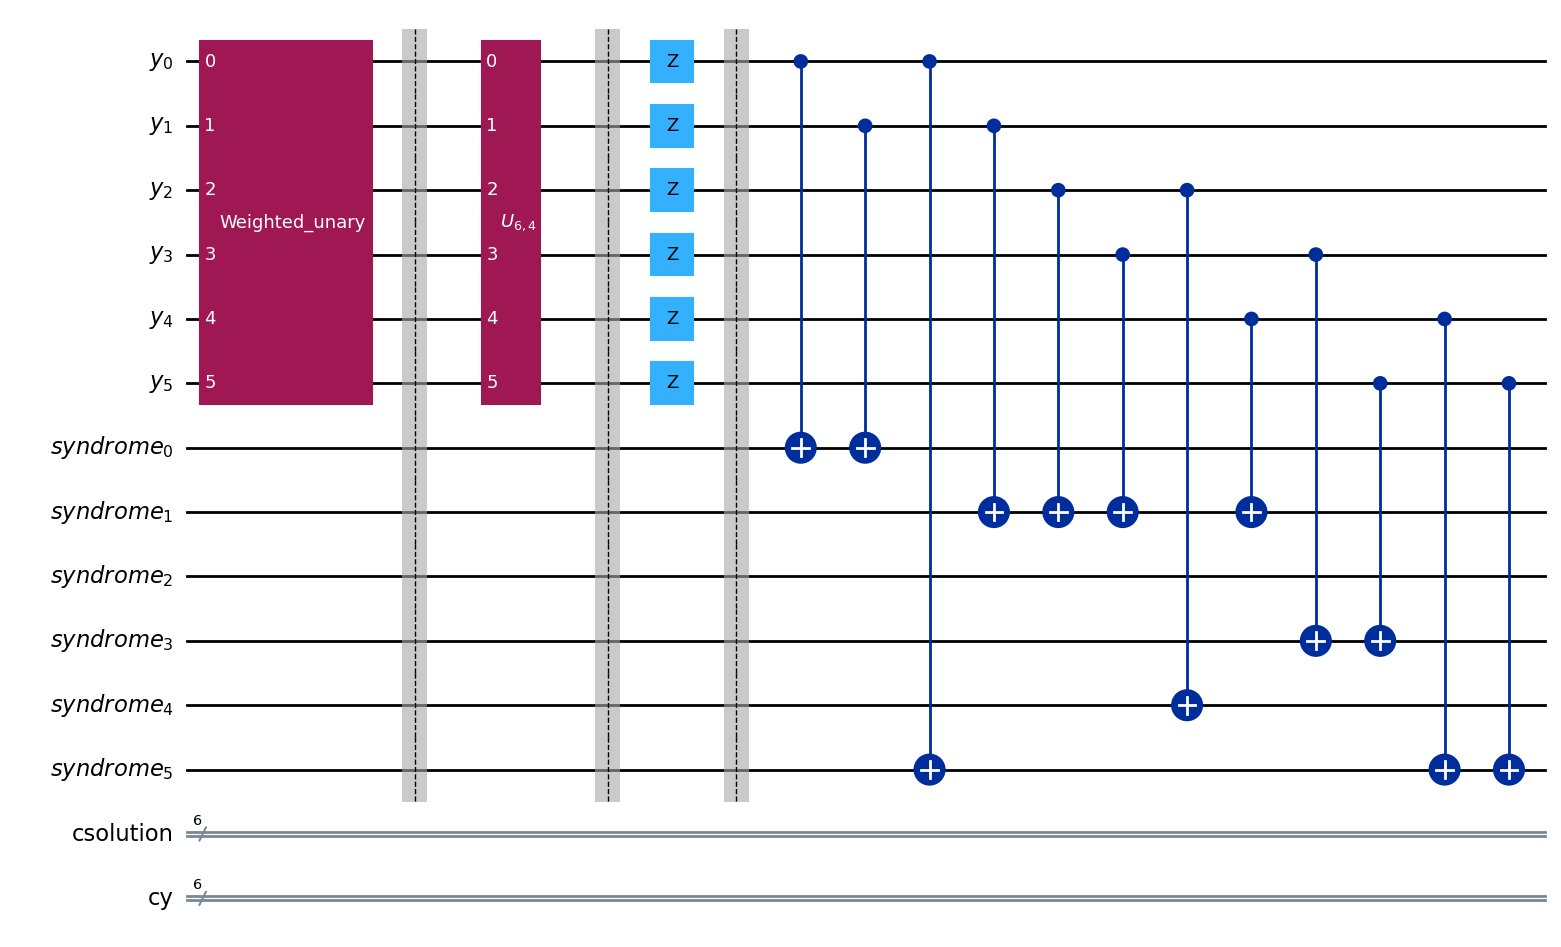

In [12]:
dqi_circuit.barrier()
dqi_circuit.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
display(dqi_circuit.draw('mpl'))

# Visualize the reduced state (if desired)
if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m))
    Statevector(np.diagonal(reduced_density_matrix)).draw('latex')



### Decoding Circuit Construction

Build the decoding circuit using the GJEGate. Depending on the sizes of the registers, the circuit
configuration varies. The decoding circuit is then appended (and its inverse is applied) to correct errors.

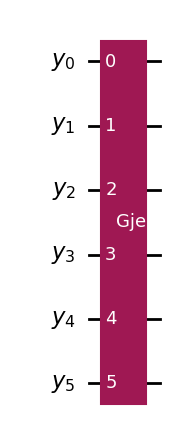

In [13]:
if n > m:
    decoding_circuit = QuantumCircuit(syndrome_qregs, name="GJE")
    GJE_gate = GJEGate(B.T)
    decoding_circuit.append(GJE_gate, range(n))
else:
    decoding_circuit = QuantumCircuit(dicke_qregs, name="GJE")
    GJE_gate = GJEGate(B.T)
    decoding_circuit.append(GJE_gate, range(n))

display(decoding_circuit.draw('mpl'))


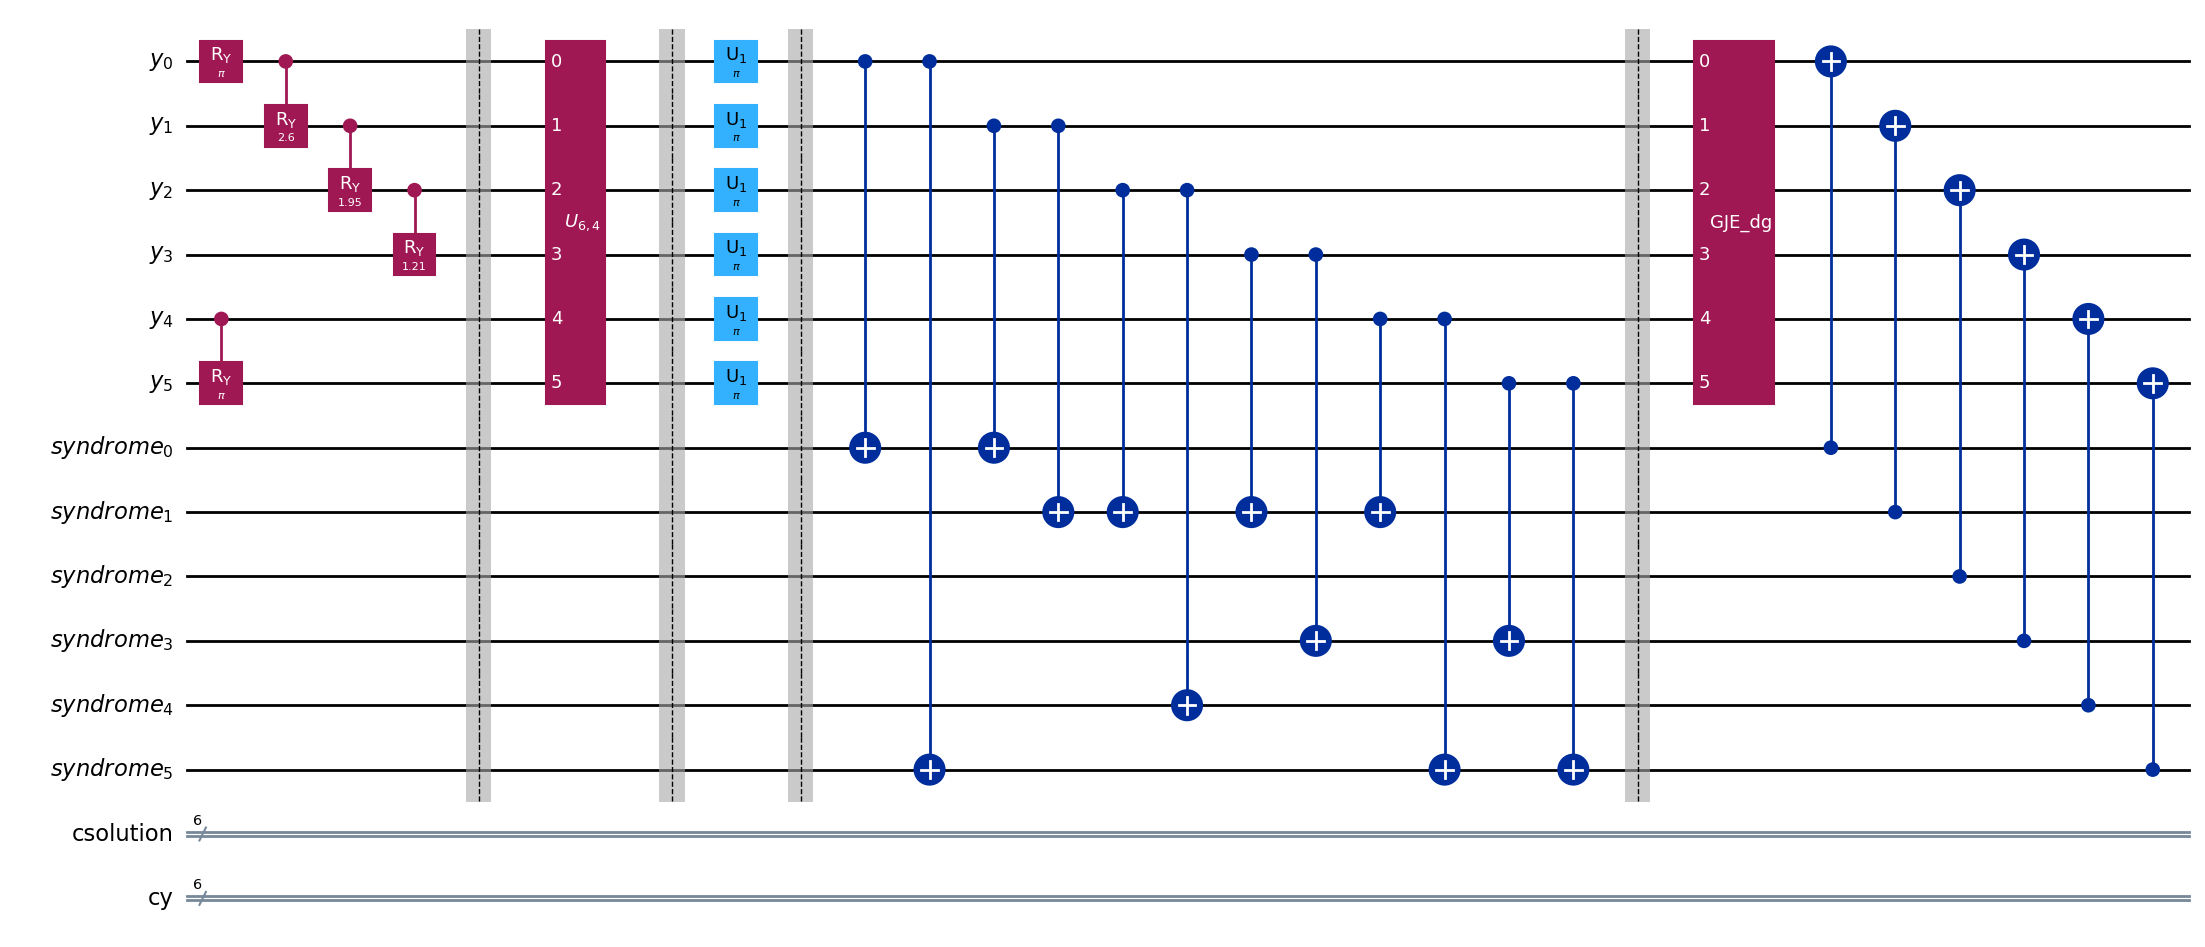

<IPython.core.display.Latex object>

In [14]:
dqi_circuit_wo_decoder = dqi_circuit.copy()
dqi_circuit.barrier()

if n > m:
    dqi_circuit.append(decoding_circuit, range(m, m+n))
    for i in range(m):
        dqi_circuit.cx(syndrome_qregs[i], dicke_qregs[i])
    dqi_circuit.append(decoding_circuit.inverse(), range(m, m+n))
else:
    dqi_circuit.append(decoding_circuit.inverse(), range(m))
    for i in range(n):
        dqi_circuit.cx(syndrome_qregs[i], dicke_qregs[i])

display(dqi_circuit.decompose().draw('mpl', fold=-1))


if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m, m+n))
    display(Statevector(np.diagonal(reduced_density_matrix)).draw('latex'))

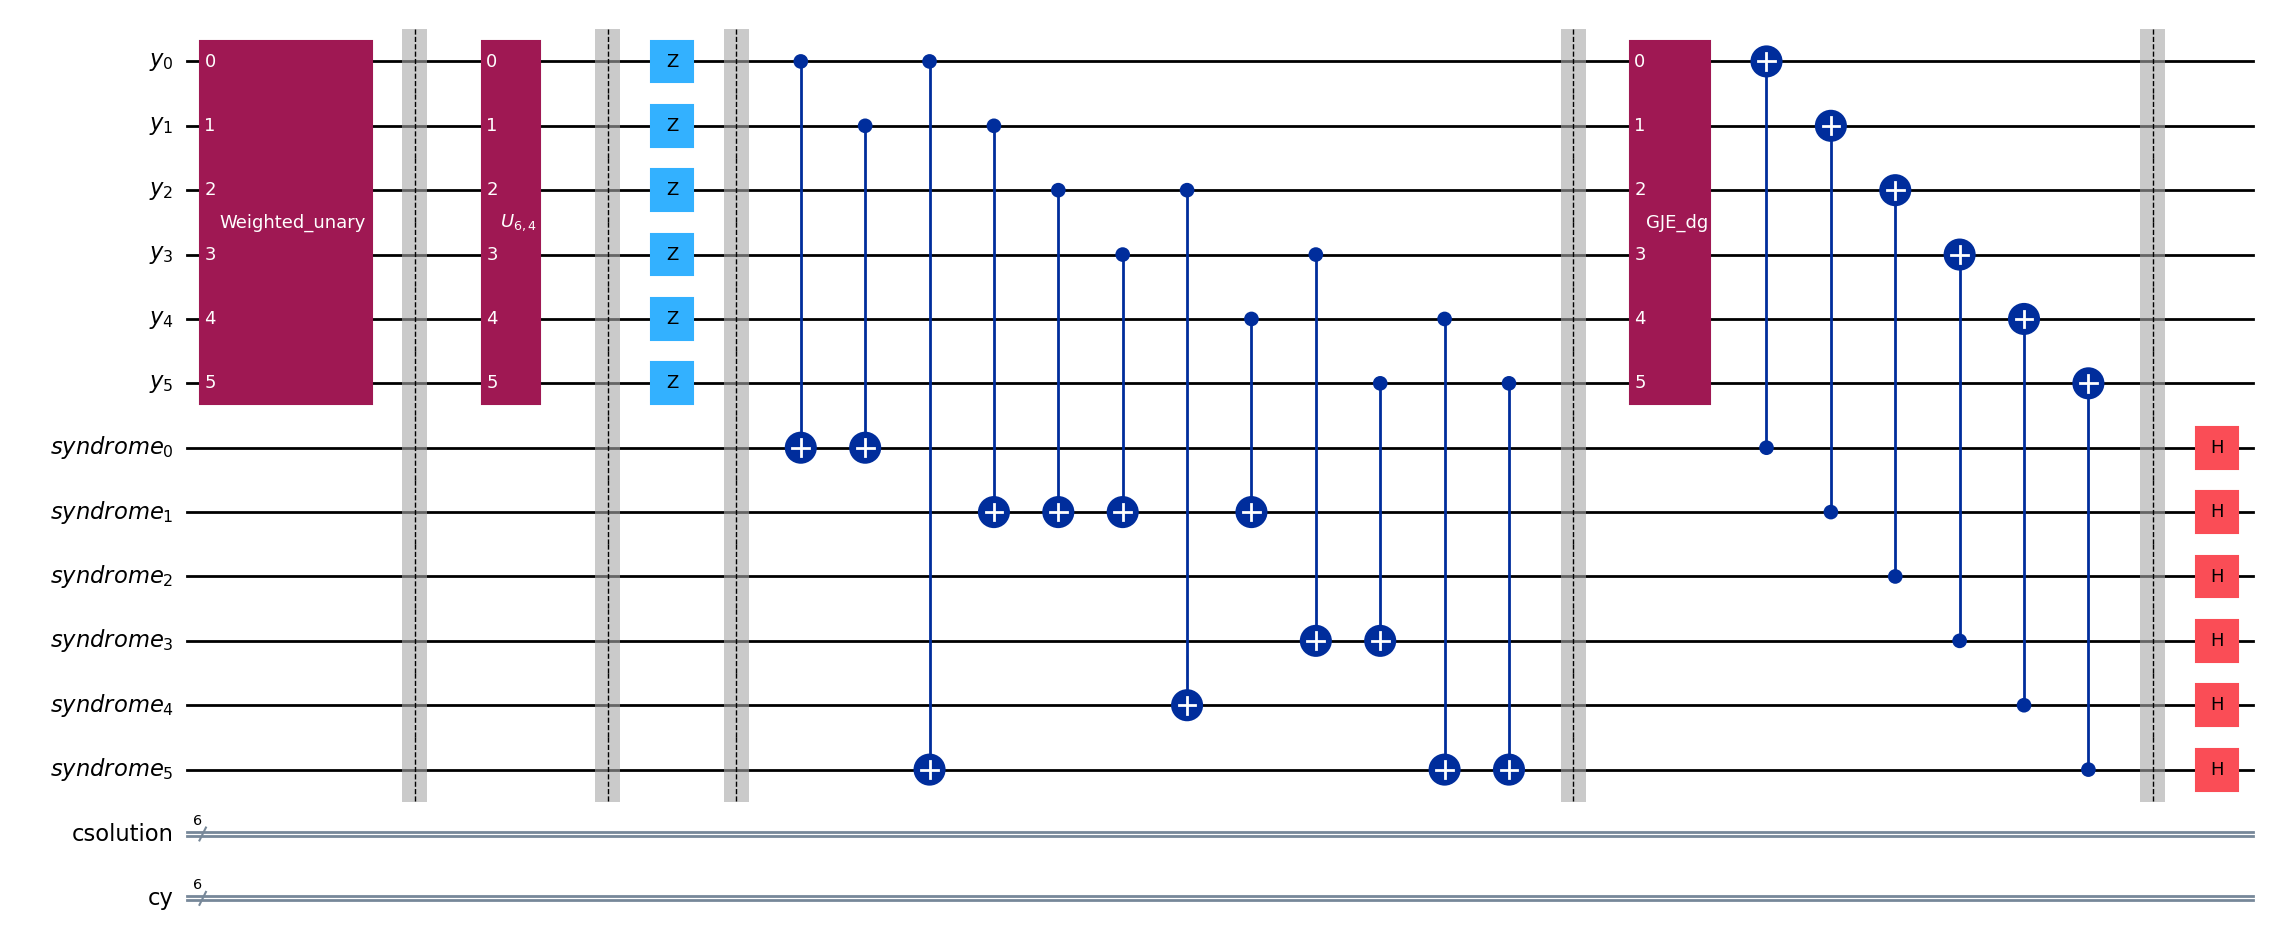

<IPython.core.display.Latex object>

In [15]:
# Hadamard Transform
dqi_circuit.barrier()
for i in range(n):
    dqi_circuit.h(m+i)
display(dqi_circuit.draw('mpl', fold=-1))

if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m, m+n))
    display(Statevector(np.diagonal(reduced_density_matrix)).draw('latex'))

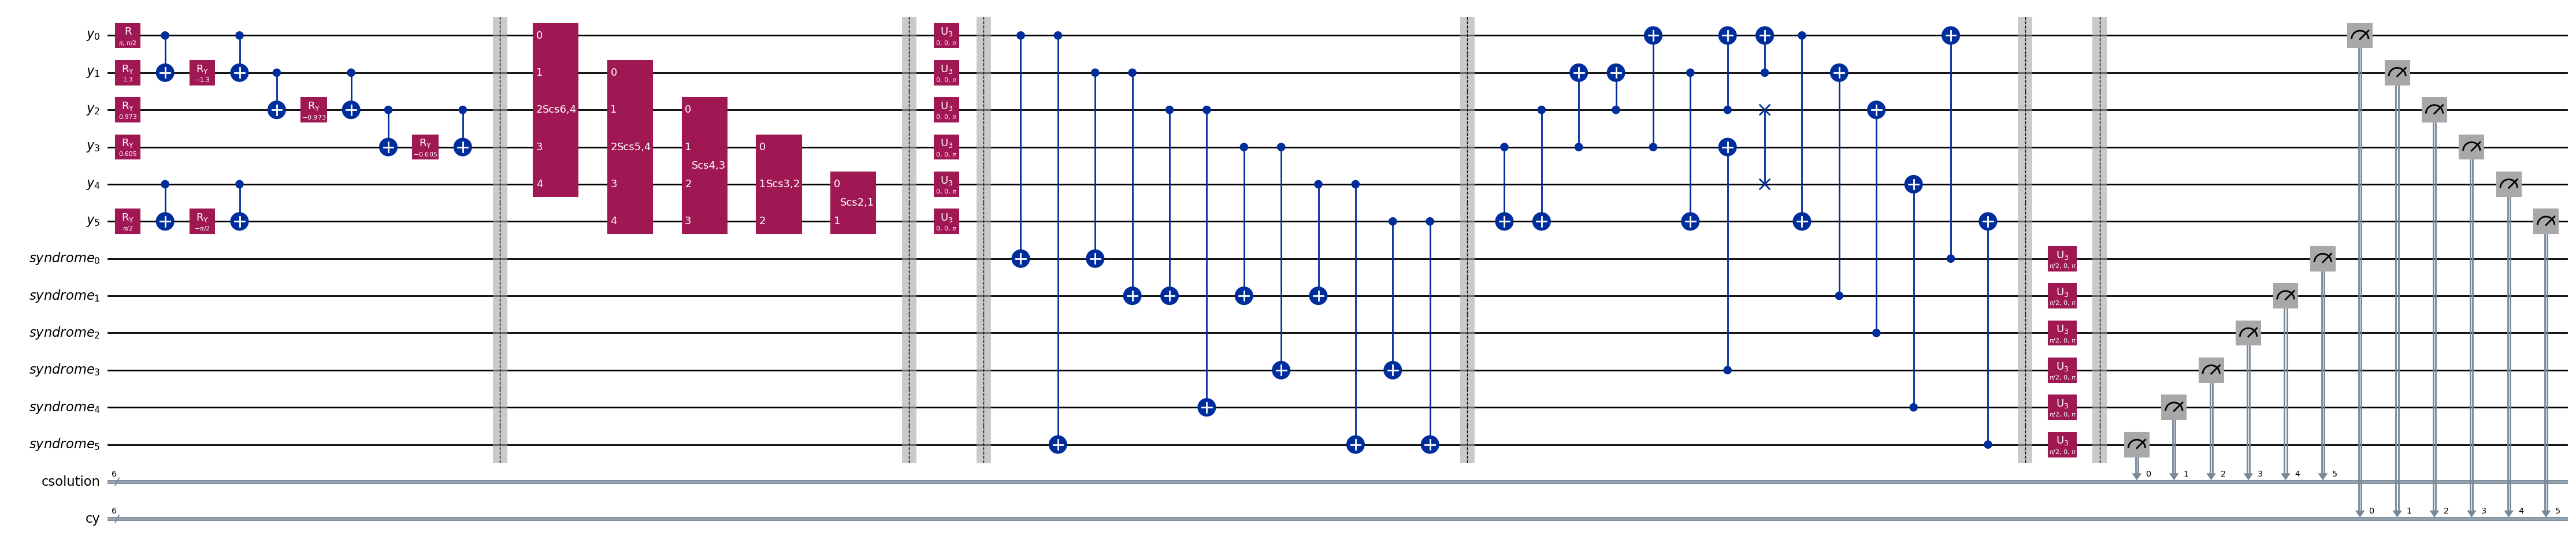

In [16]:
# Measurement
dqi_circuit.barrier()
dqi_circuit.measure(dicke_qregs, dicke_cregs)
dqi_circuit.measure(syndrome_qregs, syndrome_cregs[::-1])
display(dqi_circuit.decompose().decompose().draw('mpl', fold=-1))

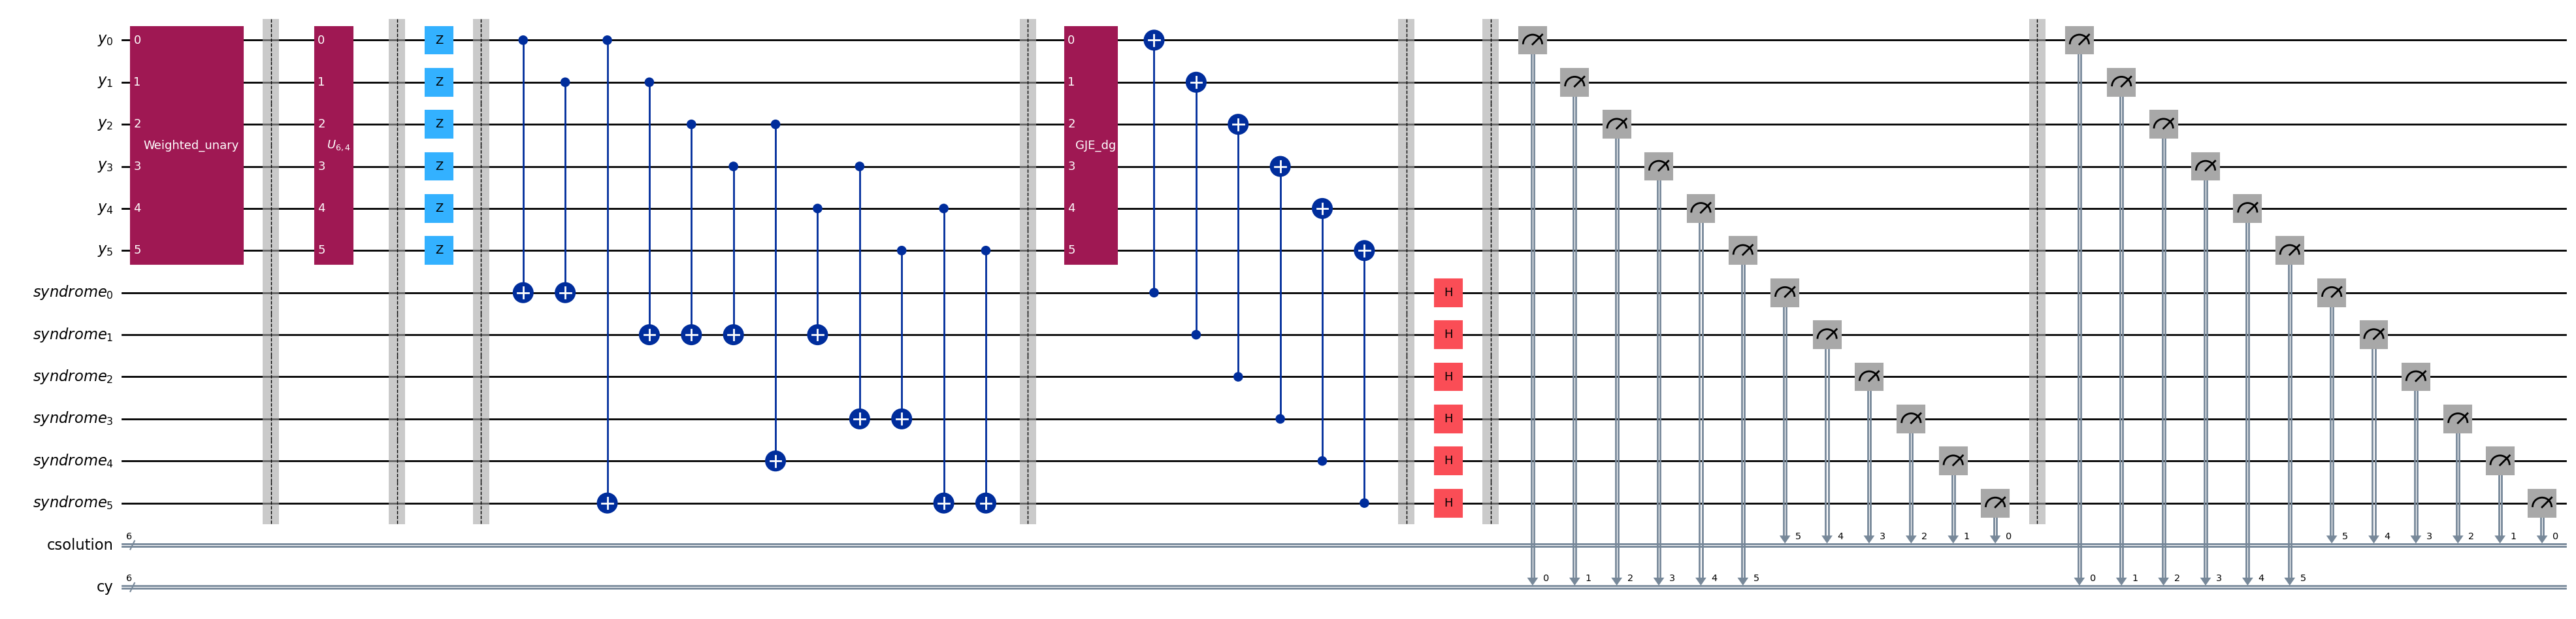

In [17]:
# Measurement
dqi_circuit.barrier()
dqi_circuit.measure(dicke_qregs, dicke_cregs)
dqi_circuit.measure(syndrome_qregs, syndrome_cregs[::-1])
display(dqi_circuit.draw('mpl', fold=-1))

## Simulation and Analysis

Run the DQI circuit on Qiskit's AerSimulator, then display and analyze the measurement counts.
Additionally, compare the brute-force objective landscape with the simulation results.

In [18]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_circuit, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_circuit)
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 18.21733 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.56148 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 2.99525 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 3.81517 (ms)
INFO:qis

{'100110 011001': 6504,
 '001000 100110': 6445,
 '001000 010001': 6435,
 '100110 100110': 6368,
 '001000 011001': 6361,
 '100110 101110': 6340,
 '001000 101110': 6241,
 '100110 010001': 6227,
 '000000 101110': 6150,
 '000000 100110': 6133,
 '000000 011001': 6109,
 '000000 010001': 6004,
 '101110 010001': 3200,
 '101110 101110': 3183,
 '101110 100110': 3161,
 '101110 011001': 3103,
 '101110 100010': 334,
 '101110 011011': 315,
 '101110 111000': 308,
 '101110 000111': 307,
 '101110 100111': 305,
 '101110 101100': 302,
 '101110 011101': 297,
 '101110 010101': 296,
 '101110 100100': 296,
 '101110 010011': 296,
 '101110 101010': 287,
 '101110 011000': 287,
 '101110 110000': 274,
 '101110 101111': 272,
 '101110 010000': 266,
 '101110 001111': 265,
 '101110 000000': 117,
 '101110 001000': 102,
 '101110 110111': 96,
 '101110 111111': 82,
 '001000 001011': 74,
 '001000 010010': 72,
 '001000 000011': 71,
 '001000 011010': 70,
 '000000 100100': 68,
 '000000 011011': 65,
 '000000 101010': 65,
 '00

In [19]:
brute_force_results = brute_force_max(B, v, first_part="0"*m)
external_data = counts  # Use simulation data for comparison
plot_results_union_plotly(
    brute_force_results,
    external_data,
    plot_name="Comparison of DQI Result and True Objective Values",
    spline_smoothing=0.8
)


Further, filter and combine the counts, then visualize the modified data.

In [20]:
external_data_filtered = {k.split(" ")[1]: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)
                          if sum([int(x) for x in k.split(" ")[0]]) == 0}
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results,
    external_data_filtered,
    plot_name="Comparison of DQI Results with True Objective Values (Post-selected on |0⟩)",
    spline_smoothing=1.3
)


In [21]:
combined_counts = combine_counts(counts)
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results,
    combined_counts,
    plot_name="Comparison of DQI Result and True Objective Values (Combined)",
    spline_smoothing=1.3
)


## Lookup Table Syndrome Decoding Gate Construction

Generate all possible error patterns and corresponding syndromes, build a syndrome lookup table, and
construct a custom syndrome decoding gate using that lookup table.

In [22]:
# Set the maximum number of errors as per ell
MAX_ERRORS = ell

# Generate error patterns: each row represents an error vector
errors = np.array([
    np.array([1 if i in ones_positions else 0 for i in range(n)])
    for num_ones in range(MAX_ERRORS + 1)
    for ones_positions in combinations(range(n), num_ones)
])[:, ::-1][:, :n]

if m > n:
    errors = np.pad(errors, ((0, 0), (0, m-n)), mode='constant', constant_values=0)

syndromes = (B.T @ errors.T % 2).T

print("Number of error patterns:", errors.shape[0])
print("Number of unique syndromes:", len(set(tuple(x) for x in list(syndromes))))
print("B shape:", B.shape)

syndrome_map = {
    "".join(map(str, synd)): "".join(map(str, err))
    for synd, err in zip(syndromes, errors)
}
print("Syndrome map:")
pp.pprint(syndrome_map)
print("Total entries in syndrome map:", len(syndrome_map))

Number of error patterns: 57
Number of unique syndromes: 16
B shape: (6, 6)
Syndrome map:
{'000000': '110101',
 '000011': '111000',
 '000101': '110011',
 '000110': '111001',
 '010001': '110000',
 '010010': '111010',
 '010100': '110110',
 '010111': '111100',
 '100001': '100111',
 '100010': '101101',
 '100100': '100110',
 '100111': '011110',
 '110000': '010111',
 '110011': '011101',
 '110101': '010110',
 '110110': '101110'}
Total entries in syndrome map: 16


Define a function to create a custom syndrome decoding gate based on the lookup table.

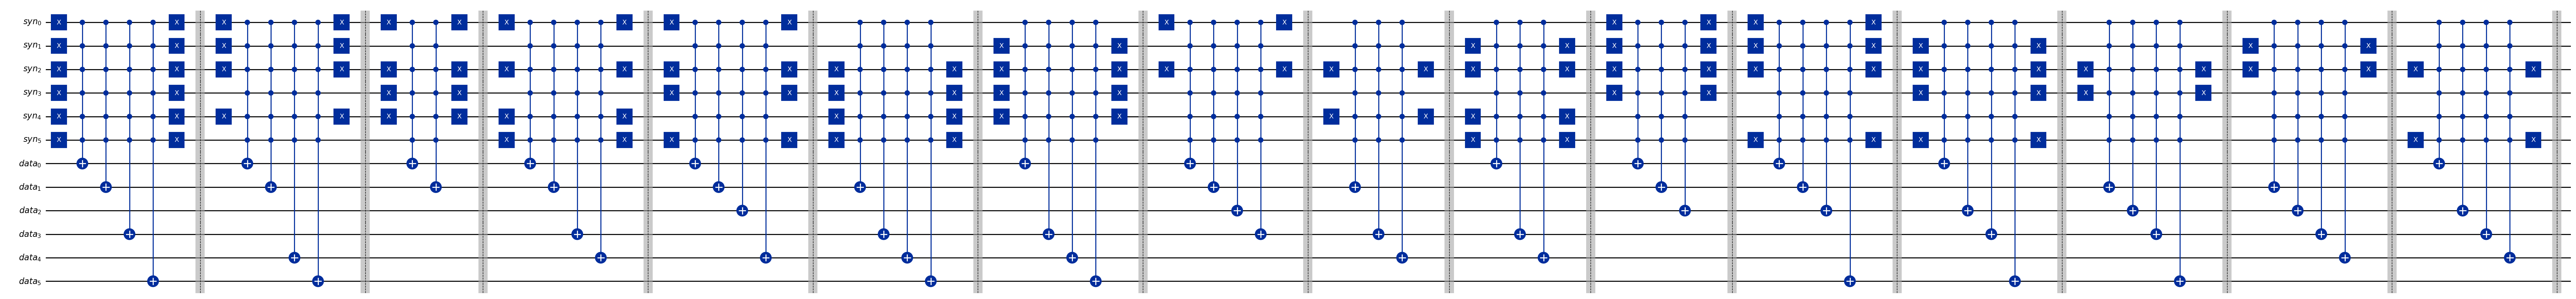

In [23]:
def syndrome_decode_lookuptable_gate(syndrome_map: dict) -> QuantumCircuit:
    """
    Create a custom Qiskit gate for syndrome decoding using a lookup table.
    
    Args:
        syndrome_map: A dictionary mapping syndrome bit-string patterns to error correction patterns.
    
    Returns:
        A QuantumCircuit implementing the syndrome decoding.
    """
    # Determine register sizes from the lookup table
    first_key = next(iter(syndrome_map.keys()))
    n_syndrome = len(first_key) if isinstance(first_key, str) else first_key.bit_length()
    first_val = next(iter(syndrome_map.values()))
    n_data = len(first_val) if isinstance(first_val, str) else first_val.bit_length()

    syndrome_reg = QuantumRegister(n_syndrome, name='syn')
    data_reg = QuantumRegister(n_data, name='data')
    circuit = QuantumCircuit(syndrome_reg, data_reg, name="syndrome_decode")

    # Process each syndrome pattern and apply the corresponding corrections
    for syndrome_pattern, error_pattern in syndrome_map.items():
        syndrome_bits = syndrome_pattern.zfill(n_syndrome) if isinstance(syndrome_pattern, str) else format(syndrome_pattern, f'0{n_syndrome}b')
        error_bits = error_pattern.zfill(n_data) if isinstance(error_pattern, str) else format(error_pattern, f'0{n_data}b')

        inverted_controls = []
        controls = []
        for idx, bit in enumerate(syndrome_bits):
            if bit == '0':
                circuit.x(syndrome_reg[idx])
                inverted_controls.append(idx)
            controls.append(syndrome_reg[idx])
        # Apply corrections: if error bit is '1', flip the corresponding data qubit
        for data_idx, bit in enumerate(error_bits):
            if bit == '1':
                if len(controls) == 1:
                    circuit.cx(controls[0], data_reg[data_idx])
                else:
                    circuit.mcx(controls, data_reg[data_idx])
        # Undo the inversions on the syndrome register
        for idx in inverted_controls:
            circuit.x(syndrome_reg[idx])
        circuit.barrier()
    
    return circuit

# Create and visualize the syndrome decoding gate
lookuptable_gate = syndrome_decode_lookuptable_gate(syndrome_map)
display(lookuptable_gate.draw('mpl', fold=-1))

## Simulation

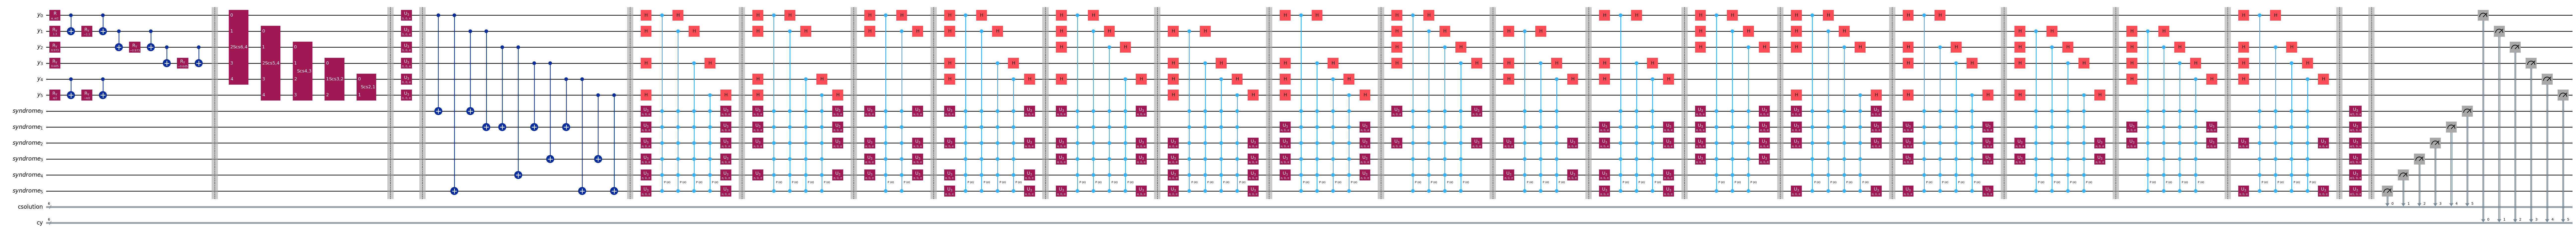

In [24]:
dqi_lookuptable = dqi_circuit_wo_decoder.copy()
dqi_lookuptable.barrier()

# Append the syndrome decoding gate to the appropriate qubits (data and syndrome registers)
dqi_lookuptable.append(lookuptable_gate, list(range(m, m+n)) + list(range(m)))

# Apply Hadamard gates to syndrome qubits for basis change
for i in range(syndrome_qregs.size):
    dqi_lookuptable.h(dicke_qregs.size + i)
dqi_lookuptable.barrier()
dqi_lookuptable.measure(dicke_qregs, dicke_cregs)
dqi_lookuptable.measure(syndrome_qregs, syndrome_cregs[::-1])
display(dqi_lookuptable.decompose().decompose().draw('mpl', fold=-1))

In [25]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_lookuptable, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_lookuptable)
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 17.60101 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.52929 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 3.24965 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.53144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 4.76241 (ms)
INFO:qis

{'010011 111001': 2412,
 '010011 110001': 2409,
 '010011 001110': 2381,
 '010011 000110': 2319,
 '101011 111111': 2215,
 '101011 000000': 2208,
 '101011 001000': 2147,
 '101011 110111': 2105,
 '000000 110111': 1946,
 '000000 001000': 1923,
 '000000 111111': 1921,
 '000000 000000': 1851,
 '111000 010101': 1845,
 '111000 101010': 1818,
 '101011 101100': 1817,
 '111000 011101': 1811,
 '111000 100010': 1807,
 '101011 010011': 1784,
 '101011 011011': 1775,
 '101011 100100': 1760,
 '010011 110111': 1756,
 '010011 001000': 1743,
 '010011 111111': 1722,
 '010011 000000': 1693,
 '111000 001000': 1530,
 '111000 110111': 1434,
 '111000 000000': 1404,
 '111000 111111': 1384,
 '000000 100010': 1105,
 '000000 111001': 1101,
 '000000 001110': 1079,
 '000000 110001': 1053,
 '000000 010101': 1025,
 '000000 101010': 1004,
 '000000 011101': 1001,
 '000000 100100': 995,
 '000000 000110': 991,
 '000000 011011': 965,
 '000000 010011': 902,
 '000000 101100': 898,
 '101011 111001': 811,
 '101011 010101': 793,

In [26]:
brute_force_results = brute_force_max(B, v, first_part="0"*m)
external_data = counts
plot_results_union_plotly(
    brute_force_results,
    external_data,
    plot_name="Comparison of DQI Result and True Objective Values (Lookup Table)",
    spline_smoothing=0.8
)

In [27]:
external_data_filtered = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)
                          if sum([int(x) for x in k.split(" ")[0]]) == 0}
brute_force_results = brute_force_max(B, v, first_part="0"*m)
plot_results_union_plotly(
    brute_force_results,
    external_data_filtered,
    plot_name="Comparison of DQI Result and True Objective Values (Post-selected on |0⟩, Lookup Table)",
    spline_smoothing=1.3
)


In [28]:
combined_counts = combine_counts(counts)
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results,
    combined_counts,
    plot_name="Comparison of DQI Result and True Objective Values (Combined, Lookup Table)",
    spline_smoothing=1.3
)